# FCCee: Full Simulation of IDEA Driftchamber


-   [Overview](#overview)
-   [Generate and Simulate Events](#generate-events)
-   [Analyze Events](#analyze-events)
-   [Plot events](#plot-events)
-   [Homework exercise](#homework-exercise)


## Overview
---------------------

-   visualize and use the Driftchamber model in FCCSW
-   simulate the particle passage in Geant4
-   run digitization and get wire signal
-   run Hough Transform for a first track reconstruction
-   produce plots

## Part I: Simulations with the IDEA detector model in  FCCSW
----------------------------------------------------

This tutorial is based on the FCC Note http://cds.cern.ch/record/2670936 and describes the use of the FCCee IDEA Driftchamber in the FCC software framework.

In [120]:
import ROOT
ROOT.enableJSVis()

In [ ]:
# load the dd4hep detector model
import dd4hep
import os
fcc_det_path = os.path.join(os.environ.get("FCC_DETECTORS", ""), "share/FCCSW/Detector/DetFCCeeIDEA/compact/FCCee_DectMaster.xml")
print fcc_det_path
description = dd4hep.Detector.getInstance()
description.fromXML(fcc_det_path)

In [ ]:
c = ROOT.TCanvas("c_detector_display", "", 600,600)
description.manager().SetVisLevel(6)
description.manager().SetVisOption(1)
vol = description.manager().GetTopVolume()
vol.Draw()


In [ ]:
!ls $FCCSWBASEDIR/share/FCCSW/Detector/DetFCCeeIDEA/compact

From the detector display or the command line, check that the detector subsystems are as you would expect them  from the specifications in the Conceptual Design Report.



In [ ]:
!export G4PARTICLEXSDATA=/usr/local/share/Geant4/data/G4PARTICLEXS1.1 && fccrun $FCCSWBASEDIR/share/FCCSW/Examples/options/geant_fullsim_fccee_pgun.py --detectors $FCCSWBASEDIR/share/FCCSW/Detector/DetFCCeeIDEA/compact/FCCee_DectMaster.xml

You can see the created files:

In [ ]:
import ROOT
f = ROOT.TFile("fccee_idea_pgun.root")
events = f.Get("events")

c = ROOT.TCanvas("c_positionedHits_DCH_xy", "", 700, 600)
# draw hits for first five events
events.Draw("positionedHits_DCH.position.x:positionedHits_DCH.position.y", "", "", 10, 0)
c.Draw()

In [ ]:
%%writefile mergeDCHits.py
import os
from Gaudi.Configuration import *


import GaudiKernel.SystemOfUnits as units
from Configurables import ApplicationMgr, FCCDataSvc, PodioOutput

podioevent   = FCCDataSvc("EventDataSvc", input="fccee_idea_pgun.root")

from Configurables import PodioInput, ReadTestConsumer
podioinput = PodioInput("PodioReader", collections=["positionedHits_DCH"], OutputLevel=DEBUG)
# Parses the given xml file
from Configurables import GeoSvc
geoservice = GeoSvc("GeoSvc", detectors=[os.environ.get("FCC_DETECTORS", "") + '/share/FCCSW/Detector/DetFCCeeIDEA/compact/FCCee_DectMaster.xml',])

from Configurables import CreateDCHHits
createhits = CreateDCHHits("CreateDCHHits",
                           readoutName = "DriftChamberCollection",
                           EdepCut = 100*1e-9,
                           DCACut = 0.8,
                           OutputLevel=INFO)

createhits.positionedHits.Path = "positionedHits_DCH"
createhits.mergedHits.Path = "merged_DCH"

from Configurables import PodioOutput
out = PodioOutput("out")
out.OutputLevel=DEBUG
out.outputCommands = ["keep *"]
out.filename="mergedDCHits.root"


ApplicationMgr( TopAlg = [
                          podioinput, 
                          createhits, 
                          out, 
                          ],
                EvtSel = 'NONE',
                EvtMax   = -1,
                ExtSvc = [podioevent, geoservice ],
                OutputLevel = INFO
 )



In [ ]:
!fccrun mergeDCHits.py

In [60]:
!rootls -t mergedDCHits.root

TTree  Sep 18 20:22 2019 events    "Events tree"
  DCHitInfo           "DCHitInfo_"           161032
    DCHitInfo.DCA         "DCA[DCHitInfo_]"         7921334
    DCHitInfo.MC_x        "MC_x[DCHitInfo_]"        7921369
    DCHitInfo.MC_y        "MC_y[DCHitInfo_]"        7921369
    DCHitInfo.MC_z        "MC_z[DCHitInfo_]"        7921369
    DCHitInfo.EdepSum     "EdepSum[DCHitInfo_]"     7921474
    DCHitInfo.TOF         "TOF[DCHitInfo_]"         7921334
    DCHitInfo.hit_start   "hit_start[DCHitInfo_]"   39283784
    DCHitInfo.hit_end     "hit_end[DCHitInfo_]"     39283516
    DCHitInfo.layerId     "layerId[DCHitInfo_]"     4001254
    DCHitInfo.wireId      "wireId[DCHitInfo_]"      4001231
    DCHitInfo.trackNum    "trackNum[DCHitInfo_]"    4001277
    DCHitInfo.cellId      "cellId[DCHitInfo_]"      7921439
    DCHitInfo.hitLength   "hitLength[DCHitInfo_]"   7921544
    DCHitInfo.radius      "radius[DCHitInfo_]"      7921439
    DCHitInfo.debug_zpos  "debug_zpos[DCHitInfo_]"  79215

And again, check that your files are present in your current directory:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DCH_xy


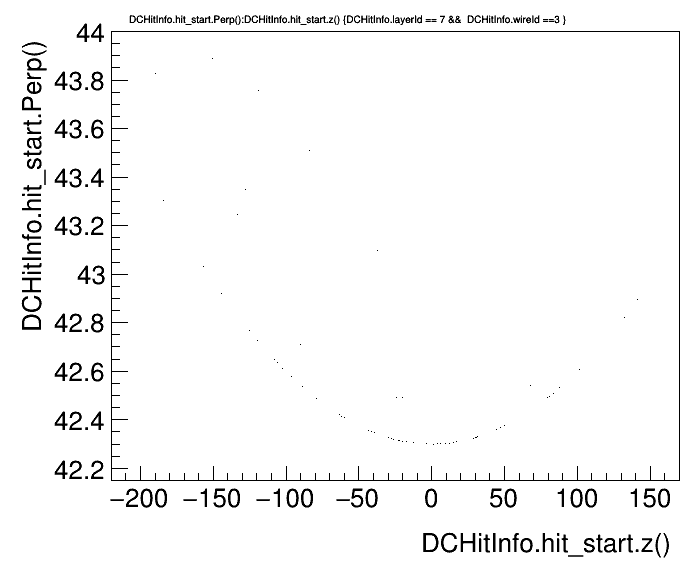

In [73]:
import ROOT
f = ROOT.TFile("mergedDCHits.root")
events = f.Get("events")

c = ROOT.TCanvas("c_DCH_xy", "", 700, 600)
# draw hits for first five events
events.Draw("DCHitInfo.hit_start.Perp():DCHitInfo.hit_start.z()", "DCHitInfo.layerId == 7 &&  DCHitInfo.wireId ==3 ", "")


c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DCH_id


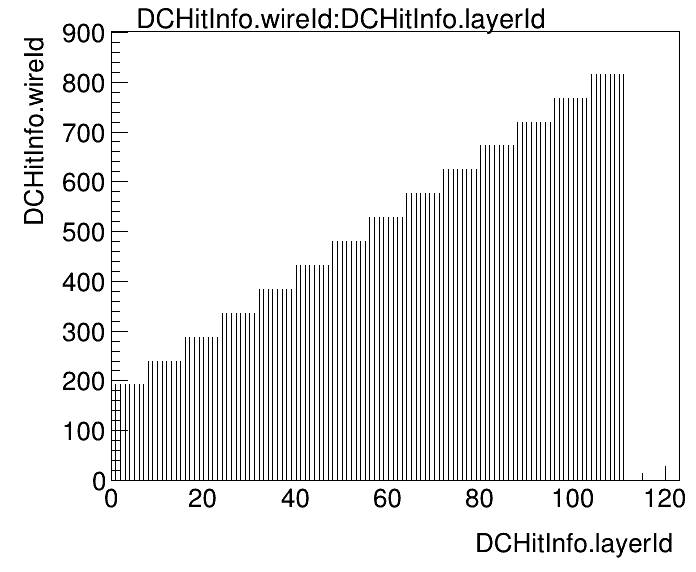

In [119]:
import ROOT
f = ROOT.TFile("mergedDCHits.root")
events = f.Get("events")


c = ROOT.TCanvas("c_DCH_id", "", 700, 600)
# draw hits for first five events
events.Draw("DCHitInfo.hit_start.x():DCHitInfo.hit_start.y()", "", "")
dat_x = events.GetV1()
dat_y = events.GetV2()
x = []
y = []
for i in range(events.GetSelectedRows()):
    x.append(dat_x[i])
    y.append(dat_y[i])
    
events.Draw("DCHitInfo.hit_start.z():DCHitInfo.hit_start.z()", "", "")
dat_z = events.GetV1()

z = []
for i in range(events.GetSelectedRows()):
    z.append(dat_z[i])
    
events.Draw("DCHitInfo.wireId:DCHitInfo.layerId", "", "")
dat_wid = events.GetV1()
dat_lid = events.GetV2()
wid = []
lid = []
for i in range(events.GetSelectedRows()):
    lid.append(dat_lid[i])
    wid.append(dat_wid[i])

c.Draw()

lid = np.array(lid)
wid = np.array(wid)
x = np.array(x)
y = np.array(y)
z = np.array(z)

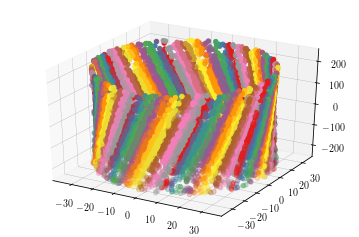

In [118]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i  in range(500):
    cond = (wid ==1 )  * (lid == i)
    f_x = x[cond]
    f_y = y[cond]
    f_z = z[cond]
    ax.scatter(f_x, f_y, f_z)
plt.show()

[]()Part II: Basic Reconstruction with a Hough-Transform
------------------------------------------

